In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk # natural language tool kit
import contractions
import string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
from nltk import pos_tag, word_tokenize   
import random
import re

from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Allen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Allen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Allen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Allen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Allen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
train = pd.read_csv('./train.tsv', sep='\t')
test = pd.read_csv('./test 2.tsv', sep = '\t')

The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

In [3]:
# Remove grammar, tokenize, and lemmatize the sentences
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        # remove non-alphabetical characters
        text = re.sub('[^a-zA-Z]', ' ', sent)
        
        # tokenize sentence
        words = word_tokenize(text.lower())
        
        # remove stop words:
        new_words = [char for char in words if char.lower() not in stopwords.words('english')]
        
        # lemmatizing each word to its lemma
        lem = WordNetLemmatizer()
        lem_words = [lem.lemmatize(i) for i in new_words]
    
        reviews.append(lem_words)

    return(reviews)

In [4]:
train_sen = clean_sentences(train)
test_sen = clean_sentences(test)

100%|██████████| 66292/66292 [03:04<00:00, 359.02it/s]


In [5]:
print(len(train['Phrase']), len(train_sen))
print(len(test['Phrase']), len(test_sen))

156060 156060
66292 66292


In [6]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [7]:
X_train,X_val,y_train,y_val = train_test_split(train_sen,y_target,
                                             test_size=0.2,stratify=y_target)

In [8]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 866661.04it/s]

13610
30


In [9]:
vocab_size = len(list(unique_words))
embedding_dim = 300
max_length = len_max
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [10]:
# Tokenize stuff
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sen)


X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 30) (31212, 30) (66292, 30)


### KNN Classifier

In [16]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

In [17]:
model.fit(X_train,y_train)
print(model.score(X_val, y_val))

0.5686274509803921


In [18]:
y_pred = model.predict(X_val)

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (2).

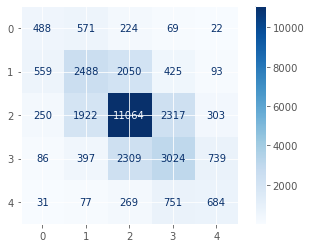

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred.argmax(axis=1), y_val.argmax(axis=1)), display_labels=np.unique(y_val))
disp.plot(cmap='Blues') 
plt.grid(False)